## notebook purpose

explore the affect of calibration region size on `im = rss(ifft(ksp*mask))`

In [43]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import copy

sys.path.append('/home/vanveen/ConvDecoder/')
from utils.transform import fft_2d, ifft_2d, root_sum_squares, \
                            reshape_complex_vals_to_adj_channels, \
                            reshape_adj_channels_to_complex_vals

### load image, mask + make lo, hi versions

In [137]:
def get_im_mask_lists(C, accel):
    
    # load mask, ksp data
    path_ss = '/bmrNAS/people/dvv/in_qdess/central_slice_in_kx/MTR_005.npy'
    path_mm = '/home/vanveen/ConvDecoder/masks/mask_pd_{}x_calib{}_rand11.npy'.format(accel, C)
    ksp = torch.from_numpy(np.load(path_ss))
    mask = torch.from_numpy(np.load(path_mm)).type(torch.uint8)
    
    accel_rate = np.around((512*80) / np.float(torch.sum(mask)), 4)
    print('actual accel rate: {}'.format(accel_rate))
    
    # make mask variants
    C_ = C // 2
    mask_lo = torch.zeros((512,160)).type(torch.uint8)
    mask_lo[256-C_:256+C_, 80-C_:80+C_] = int(1)
    mask_hi = copy.deepcopy(mask)
    mask_hi[256-C_:256+C_, 80-C_:80+C_] = int(0)
    
    # mask im + variants
    im = root_sum_squares(ifft_2d(ksp))
    im_down = root_sum_squares(ifft_2d(ksp * mask))
    im_lo = root_sum_squares(ifft_2d(ksp * mask_lo))
    im_hi = root_sum_squares(ifft_2d(ksp * mask_hi))
    
    im_list = [im, im_down, im_lo, im_hi]
    mask_list = [mask, mask_lo, mask_hi]
    
    return im_list, mask_list

def plot_masks(mask_list, C):
    
    title_list = ['mask', 'mask_lo', 'mask_hi']
    
    plt.figure(figsize=(3,3))
    
    for idx, mask in enumerate(mask_list):
        
        title = '{}, C={}'.format(title_list[idx], C)
        
        plt.subplot(1, len(mask_list), idx+1)
        plt.title(title, size=7)
        plt.imshow(mask, cmap='gray')
        plt.axis('off')
        
    plt.show()
    
def plot_ims(im_list, C):
    
    title_list = ['im', 'im*mask', 'im*mask_lo', 'im*mask_hi']
    
    plt.figure(figsize=(10,10))
    
    for idx, im in enumerate(im_list):
        
        if idx != 0:
            title = '{}, C={}'.format(title_list[idx], C)
        else:
            title = title_list[idx]
        
        plt.subplot(1, len(im_list), idx+1)
        plt.title(title)
        plt.imshow(im, cmap='gray', aspect = 1./2.56)
        plt.axis('off')
        
    plt.show()

actual accel rate: 3.9748


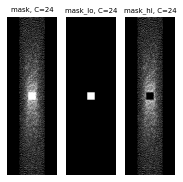

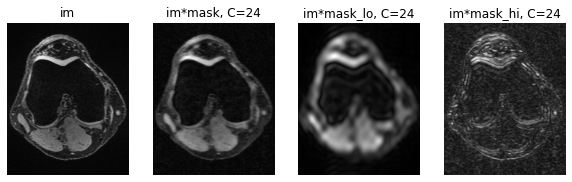

actual accel rate: 3.9339


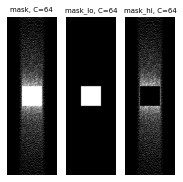

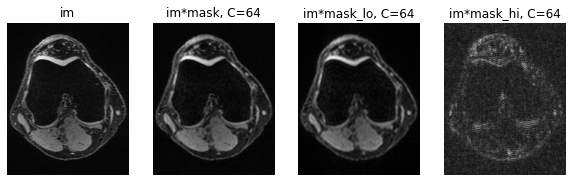

In [140]:
accel = 4
C = 24 # size of calib region

for C in [24, 64]:
    
    im_list, mask_list = get_im_mask_lists(C, accel)
    
    plot_masks(mask_list, C)
    plot_ims(im_list, C)